# Data Explorer

This notebook provides tools and visualizations to explore and analyze datasets in the project.

**Project:** CondGeoLDM  
**Author:** Pierre  
**Date:** 2024-06


## Basic file loading


In [55]:
import numpy as np
charac = np.load('/projects/iktos/pierre/CondGeoLDM/data/jump/charac_30_h.npy', allow_pickle=True)

## Modify args.pickle in checkpoints

In [1]:
import pickle
print(os.getcwd())
args_path = '/projects/iktos/pierre/CondGeoLDM/outputs/geom_pretrained/args.pickle'
with open(args_path, 'rb') as f:
    args_j = pickle.load(f)
args_j

#MODIFY YOUR ARGS HERE 
args_j.datadir = "/import/pr_iktos/pierre/CondGeoLDM"
# # # Uncomment to save args_j
with open(args_path, 'wb') as f:
    pickle.dump(args_j, f)

NameError: name 'os' is not defined

# Tanimoto Similarities


In [1]:
import numpy as np
import pandas as pd
import metrics.fidelity as fidelity
from metrics.fidelity import compute_stacked_histogram, read_fingerprints_file
from importlib import reload
reload(fidelity)
# rax fp
geom_fp = read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/geom_fingerprints.npy")
jump_fp = read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/jump_fingerprints.npy")
self_sim_geom = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/self_sim_geom.npy', allow_pickle=True)
self_sim_qm9 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/self_sim_qm9.npy', allow_pickle=True)

#refs
mal_jump_50k = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jump_50k.npy', allow_pickle=True)
mal_qm9_20k= np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_qm9_20k.npy', allow_pickle=True)
mal_geom_50k = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_geom_50k.npy', allow_pickle=True)

#mallat geom
mal_geoLDM = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_geoldm.npy', allow_pickle=True)
mal_semla = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_semla.npy', allow_pickle=True)
mal_flowmol = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_flowmol.npy', allow_pickle=True)
mal_gcdm= np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_gcdm.npy', allow_pickle=True)

# mallat qm9
mal_semla_qm9 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_semla_qm9.npy', allow_pickle=True)
mal_gcdm_qm9 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_gcdm_qm9.npy', allow_pickle=True)
mal_semla_nopp = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_semla_nopp.npy', allow_pickle=True)

#mallat jump
mal_jumpxatt = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jumpxatt.npy', allow_pickle=True)
mal_jumpvanilla = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jumpvanilla.npy', allow_pickle=True)
mal_jump0 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jumpphen0.npy', allow_pickle=True)
mal_jump1 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jumpphen1.npy', allow_pickle=True)
mal_jump2 = np.load('/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/best_hits_jumpphen2.npy', allow_pickle=True)
print(len(geom_fp))

268658


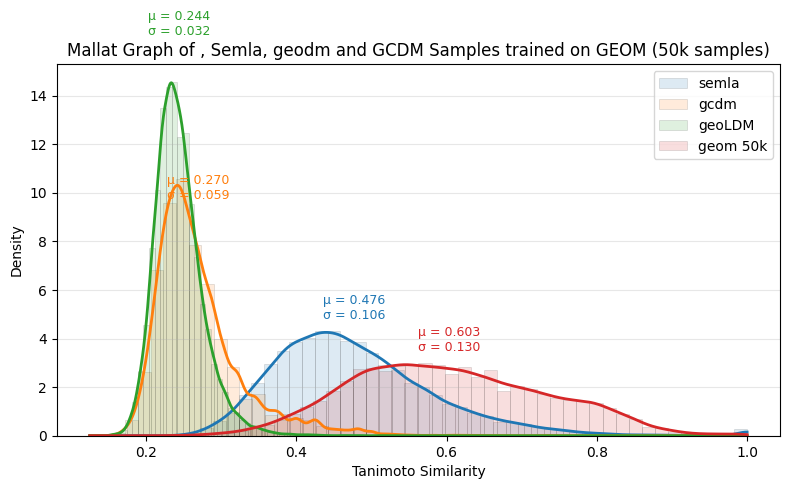

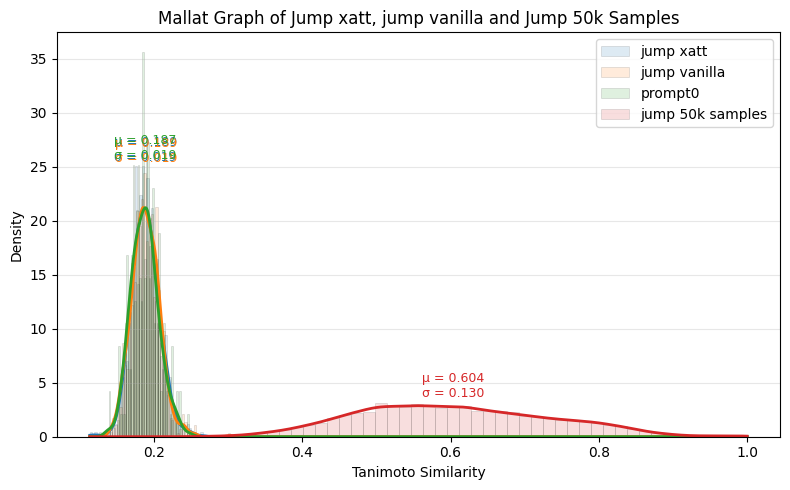

In [6]:

compute_stacked_histogram([mal_semla[:,0], mal_gcdm[:,0], mal_geoLDM[:,0], mal_geom_50k[:,0],  ],
                          labels=["semla","gcdm","geoLDM", "geom 50k"  ],
                          save_path="metrics/figures/mallat_test_global.png", 
                          bins=50,
                          title="Mallat Graph of , Semla, geodm and GCDM Samples trained on GEOM (50k samples)")
                          
                        #   labels= ["Similarities of Flowmol generations", "Similarities of Semla generations", "Similarities of GCDM generations", "Similarities of GEOM_50k"],
                        #   save_path="metrics/figures/mallat_global_50k.png", 
                        #   title="Mallat Graph of Flowmol, Semla and GCDM Samples trained on GEOM (50k samples)")

compute_stacked_histogram([mal_jumpxatt[:,0], mal_jumpvanilla[:,0], mal_jump0[:,0],mal_jump_50k[:,0]],
                          labels=["jump xatt", "jump vanilla" , "prompt0", "jump 50k samples"],
                          save_path="metrics/figures/mallat_jump_global.png", 
                          bins=50,
                          title="Mallat Graph of Jump xatt, jump vanilla and Jump 50k Samples")

## Test of fidelity metrics


In [2]:
import os
from metrics import fidelity
import numpy as np

import eval_script
import pickle
import torch
import argparse
from equivariant_diffusion.utils import assert_correctly_masked
from qm9.sampling import sample_chain, sample
import qm9.visualizer as vis
from qm9.models import get_latent_diffusion
from configs.datasets_config import get_dataset_info
from qm9 import dataset, losses
from metrics.viability import analyze_stability_for_molecules, check_stability
from importlib import reload
parser = argparse.ArgumentParser(
    description="Sample mol with conditioning drawn from clusters")

# parser.add_argument(
#     "--n_samples", type=int, default=10, help="Number of samples to generate")
# parser.add_argument(
#     "--n_tries",type=int, default=50,help="Number of tries to find stable molecules",)
# parser.add_argument(
#     "--data_file",type=str, default="/projects/iktos/pierre/CondGeoLDM/data/jump/charac_30_h.npy",
#     help="Conditioning type: geom, jump, or both")

# parser.add_argument("--model_path", type=str, default="/projects/iktos/pierre/CondGeoLDM/outputs/only_ae")
# parser.add_argument("--stable_only", type=bool, default="False")
# parser.add_argument("--visualise_chain", type=bool, default="False")
# parser.add_argument("--save_samples", type=bool, default = "False")
# parser.add_argument(
#     "--n_nodes",type=int, default=44 ,help="Size of fixed-sized generation")
# # Parse the arguments
# eval_args, _ = parser.parse_known_args()
# print(eval_args)
# assert eval_args.model_path is not None

# with open(os.path.join(eval_args.model_path, "args.pickle"), "rb") as f:
#     args = pickle.load(f)

# args.cuda = not args.no_cuda and torch.cuda.is_available()
# device = torch.device("cuda" if args.cuda else "cpu")
# args.device = device
# dtype = torch.float32

# # Retrieve dataset info and dataloaders
# dataset_info = get_dataset_info(args.dataset, args.remove_h)

# dataloaders, charge_scale = dataset.retrieve_dataloaders(args)

# flow, nodes_dist, prop_dist = get_latent_diffusion(
#     args, device, dataset_info, dataloaders["train"]
# )
# # if prop_dist is not None:
# #     property_norms = compute_mean_mad(dataloaders, args.conditioning, args.dataset)
# #     prop_dist.set_normalizer(property_norms)
# flow.to(device)

# fn = "generative_model_ema.npy" if args.ema_decay > 0 else "generative_model.npy"
# flow_state_dict = torch.load(os.path.join(eval_args.model_path, fn), map_location=device)
# flow.load_state_dict(flow_state_dict)

In [ ]:
sum(p.numel() for p in flow.parameters())
sum(p.numel() for p in flow.parameters() if p.requires_grad)

5482021

: 

In [12]:
vae_state_dict = flow.vae.state_dict()
vae_np_dict = {k: v.cpu().numpy() for k, v in vae_state_dict.items()}
torch.save(flow.vae.state_dict(), "/projects/iktos/pierre/CondGeoLDM/outputs/jump_xatt_h_3000%_25e_resume/vae/generative_model_ema.npy")

with open('outputs/jump_xatt_h_3000%_25e_resume/vae/args.pickle', 'wb') as f:
    pickle.dump(args, f)

In [ ]:
sum(p.numel() for p in flow.vae.parameters() if p.requires_grad)
sum(p.numel() for p in flow.vae.parameters() if p.requires_grad)

# flow

2373383


3108638

In [68]:
reload(eval_script)
one_hot, charges, x, node_mask = eval_script.sample_only_stable_different_sizes(
    args,
    eval_args,
    device,
    flow,
    nodes_dist,
    dataset_info,
    n_samples=50,
    n_tries=51,
    save=eval_args.save_samples,
)

0it [00:00, ?it/s]

1000it [06:12,  2.68it/s]


In [ ]:

reload(eval_script)
molecules_list = eval_script.graph_to_mol_list(one_hot=one_hot, charges=charges, x=x, node_mask=node_mask)
stability_dict, rdkit_metrics, mols = analyze_stability_for_molecules(
    molecules_list, 
    dataset_info,
    parallel=False
)
# TODO : GetLargestFragment(mol) change til les distances tanimoto ? 
print(stability_dict, rdkit_metrics)

Computing stability: 100%|██████████| 50/50 [00:03<00:00, 15.90it/s]
[15:43:36] Explicit valence for atom # 19 N, 4, is greater than permitted


Validity over 50 molecules: 98.00%

              Connectivity over 50 molecules: 40.00%
Uniqueness over 49 valid molecules: 100.00%
{'mol_stable': 0.0, 'atm_stable': 0.7734194739270881} [0.98, 1.0, 0.0, 0.4]


In [70]:
mols

In [ ]:
for i in range(mols.size()[0]):
    save_xyz_file(
        f"./temp/nul/{i}",
        one_hot[i].unsqueeze(0),
        charges[i].unsqueeze(0),
        x[i].unsqueeze(0),
        dataset_info,
        0,
        "",
        node_mask[i].unsqueeze(0))

In [18]:
# reload(fidelity)
from metrics import fidelity 

fp = fidelity.rdkit_mols_to_fingerprints(mols, fp_size=1024)
print(len(fp))
fidelity.save_fingerprints_file(fp, '/projects/iktos/pierre/CondGeoLDM/TEMPFP_jump')

39


In [21]:
# - visualiser les générations 
# Parameters
import matplotlib.pyplot as plt
from PIL import Image
n_images = 10
gen_folder = "temp/samples"
gt_folder = "temp/gt"

# Prepare image grid
fig, axes = plt.subplots(n_images, 2, figsize=(6, n_images * 2.5))

for i in range(n_images):
    # File names
    gen_path = os.path.join(gen_folder, f"{i}_01_000.png")
    gt_path = os.path.join(gt_folder, f"gt{i}_01_000.png")

    # Load images
    gen_img = Image.open(gen_path)
    gt_img = Image.open(gt_path)

    # Plot
    axes[i, 0].imshow(gt_img)
    axes[i, 0].set_title(f"GT {i}, similarity {ret3[i]:4f}")
    axes[i, 1].imshow(gen_img)
    axes[i, 1].set_title(f"Generated {i}")

    for j in range(2):
        axes[i, j].axis("off")

plt.tight_layout()
plt.savefig("temp/grid.png")
plt.show()


/tmp/ipykernel_2261705/2814354691.py:32: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


## Umap on both DS

umap for jump distribs


/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


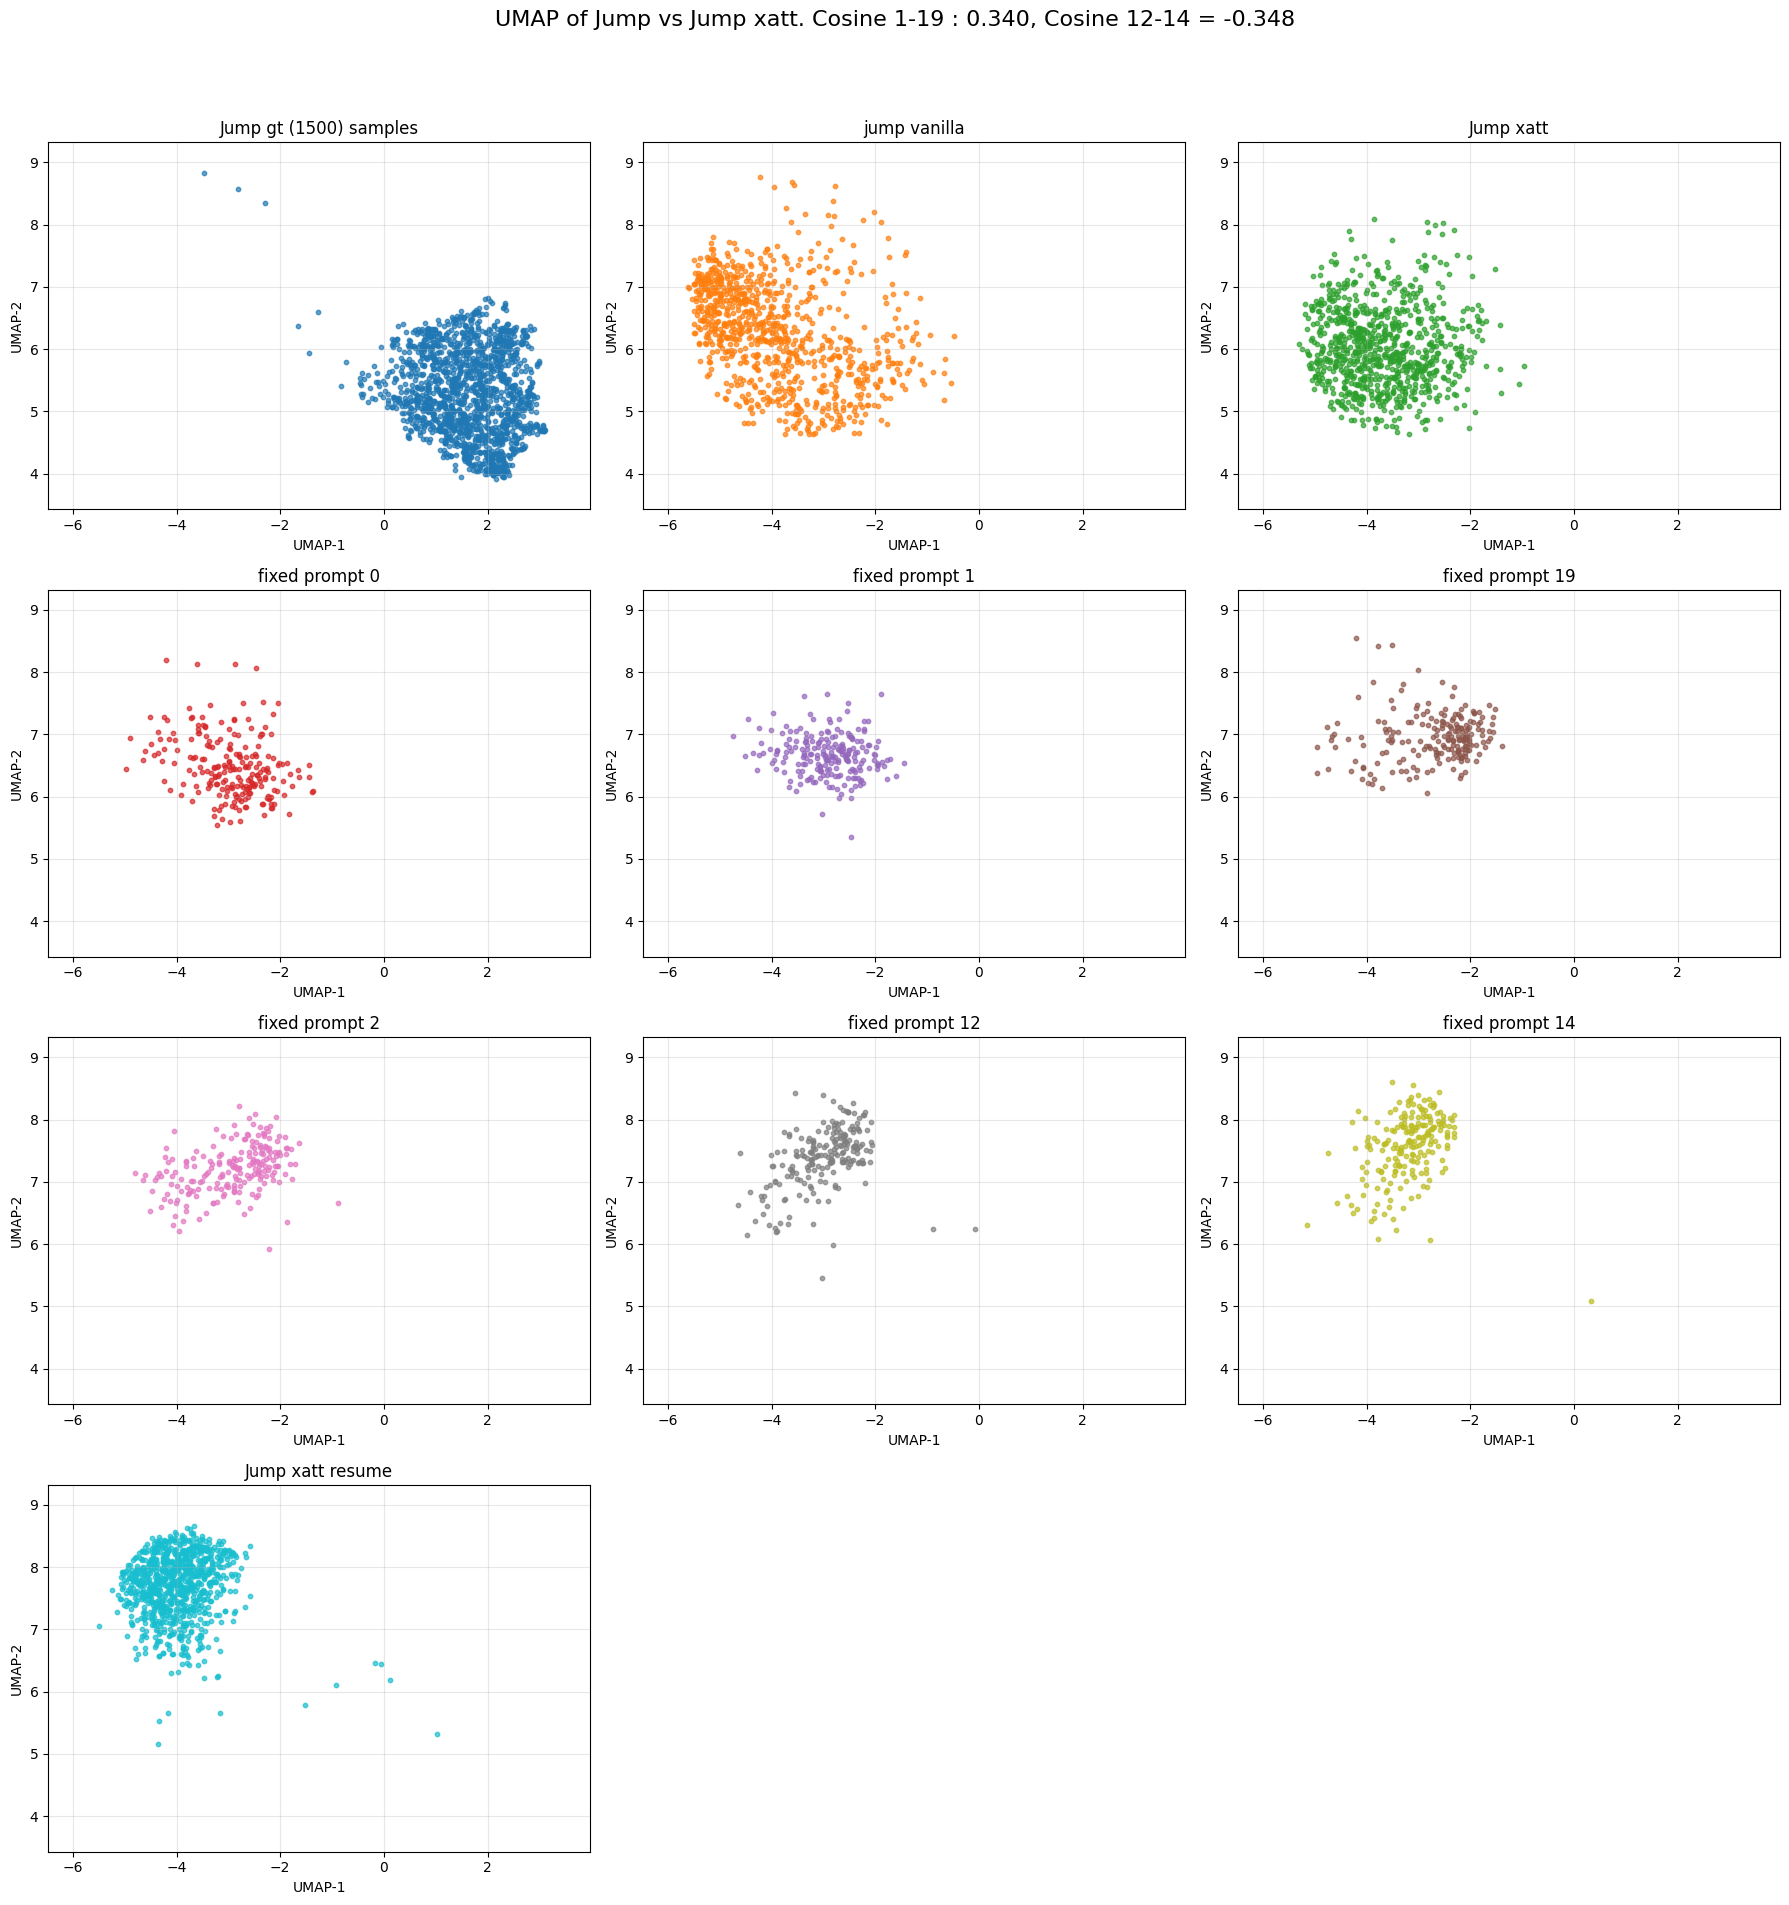

Data type: <class 'numpy.ndarray'>
Shape: (2983, 1024)


/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


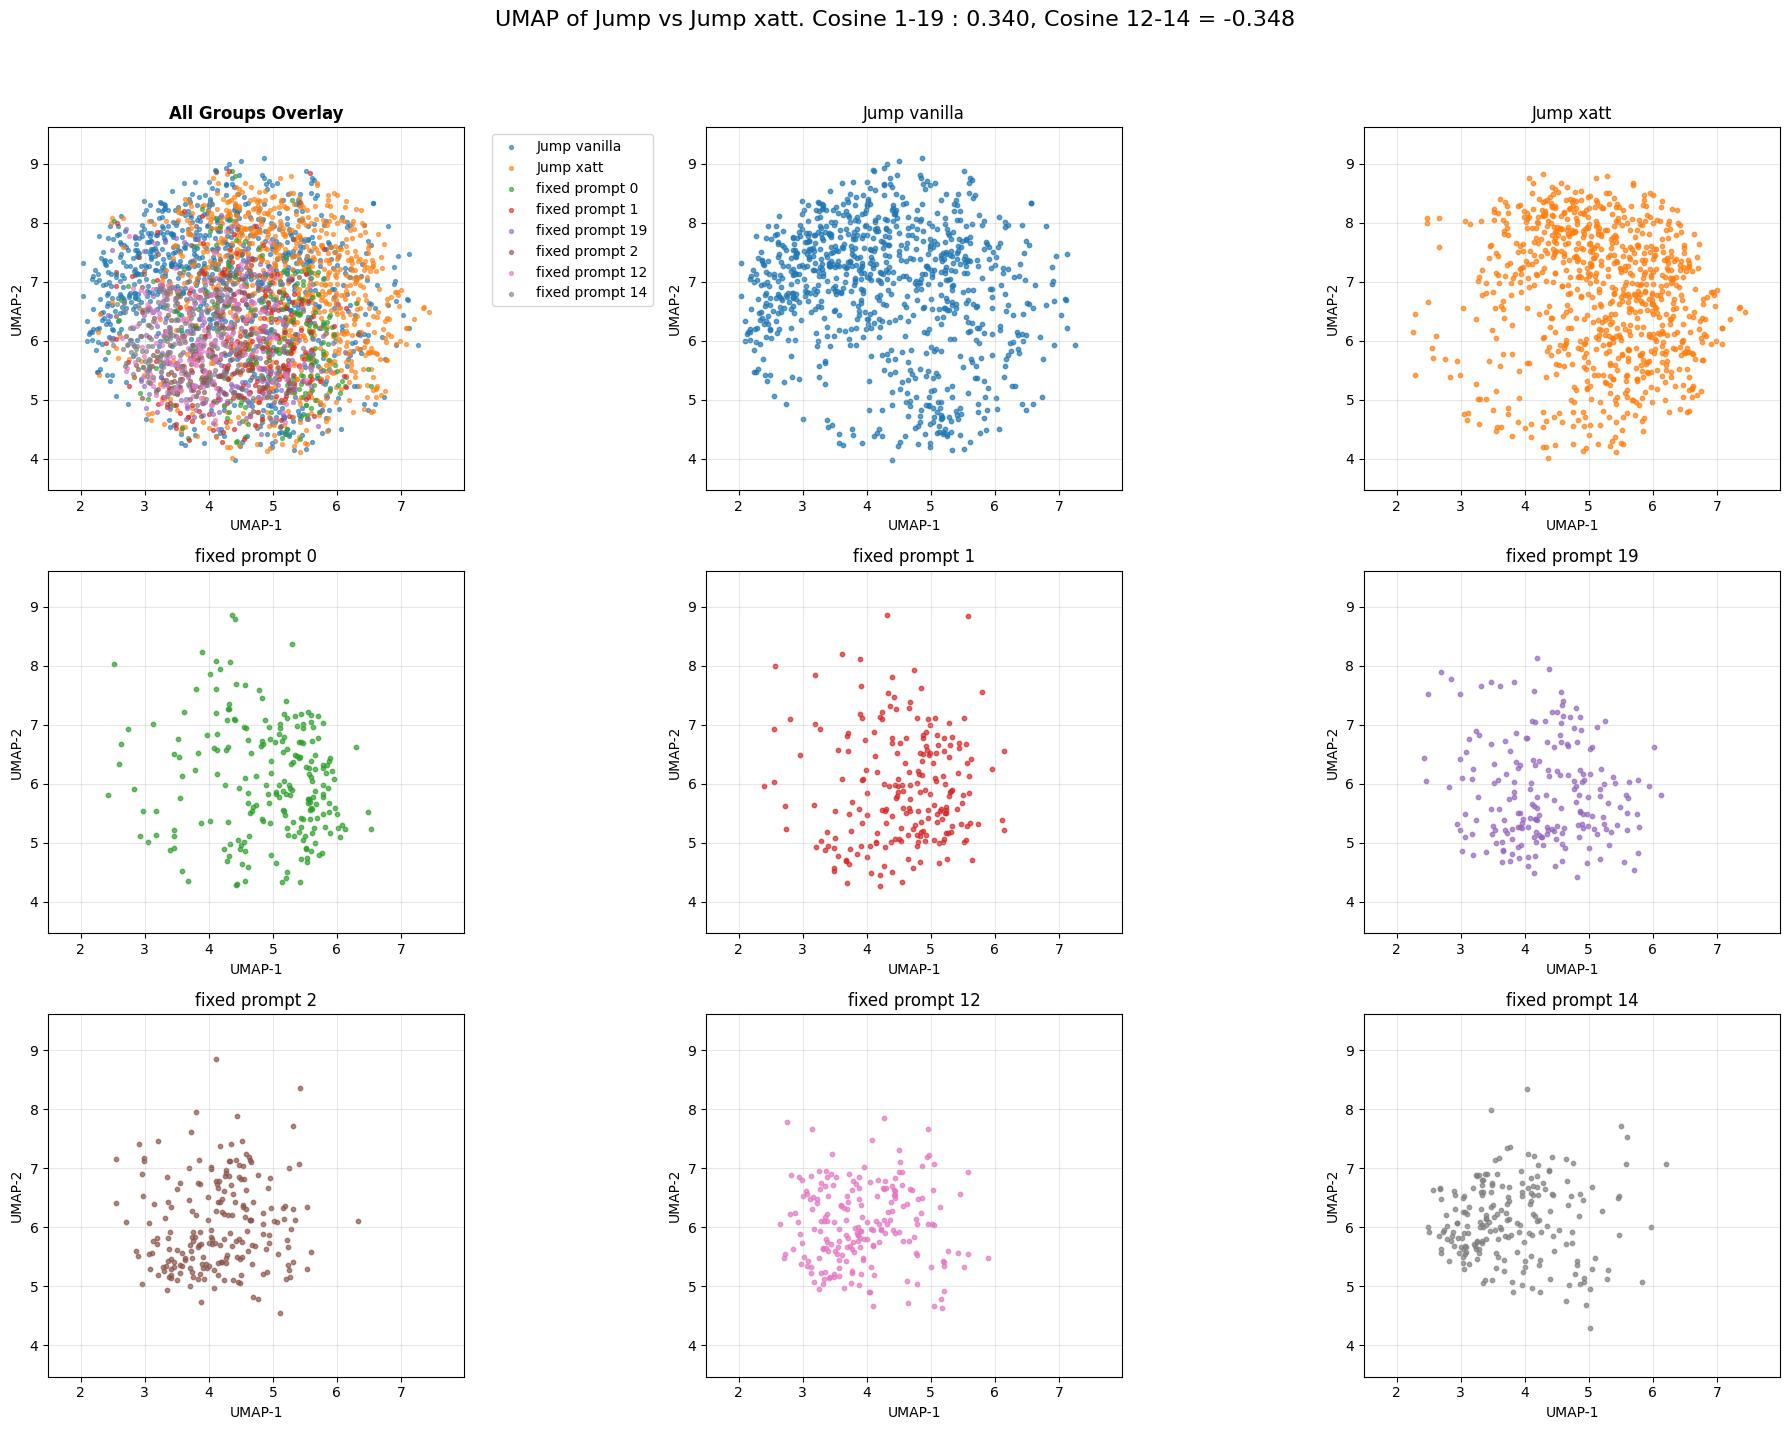

(array([[2.4147282, 6.590518 ],
        [2.4219022, 7.7342715],
        [5.837309 , 4.6815543],
        ...,
        [4.143468 , 7.209962 ],
        [4.7211976, 6.5287905],
        [3.3416622, 6.795489 ]], dtype=float32),
 array([0, 0, 0, ..., 7, 7, 7]))

In [4]:
import metrics.fidelity as fidelity
from importlib import reload
reload(fidelity)
mask = np.random.choice(len(jump_fp), size=1500, replace=False)
vanilla_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpvanilla_from_jump.npy")
xatt_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpxatt_from_jump.npy")
prompt0_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpphen0_from_jump.npy")
prompt1_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpphen1_from_jump.npy")
prompt2_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpphen2_from_jump.npy")
prompt12_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpphen12_from_jump.npy")
prompt14_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpphen14_from_jump.npy")
prompt19_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpphen19_from_jump.npy")
xattresume3_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_jumpxattresume3_from_jump.npy")
fidelity.compute_stacked_umap([jump_fp[mask], vanilla_fp, xatt_fp, prompt0_fp, 
                               prompt1_fp, prompt19_fp, prompt2_fp, prompt12_fp, prompt14_fp, xattresume3_fp],
                              labels=[f"Jump gt ({len(mask)}) samples", "jump vanilla", "Jump xatt", "fixed prompt 0", 
                                      "fixed prompt 1", "fixed prompt 19", "fixed prompt 2", "fixed prompt 12", 
                                      "fixed prompt 14", "Jump xatt resume"],
                              save_path="metrics/figures/umap_jump_vs_xatt.png",
                              title="UMAP of Jump vs Jump xatt. Cosine 1-19 : 0.340, Cosine 12-14 = -0.348")

fidelity.compute_stacked_umap_with_overlay([vanilla_fp, xatt_fp, prompt0_fp, 
                               prompt1_fp, prompt19_fp, prompt2_fp, prompt12_fp, prompt14_fp],
                              labels=["Jump vanilla", "Jump xatt", "fixed prompt 0", 
                                      "fixed prompt 1", "fixed prompt 19", "fixed prompt 2", "fixed prompt 12", "fixed prompt 14"],
                              save_path="metrics/figures/umap_jump_vs_xatt_overlay.png",
                              title="UMAP of Jump vs Jump xatt. Cosine 1-19 : 0.340, Cosine 12-14 = -0.348")

/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


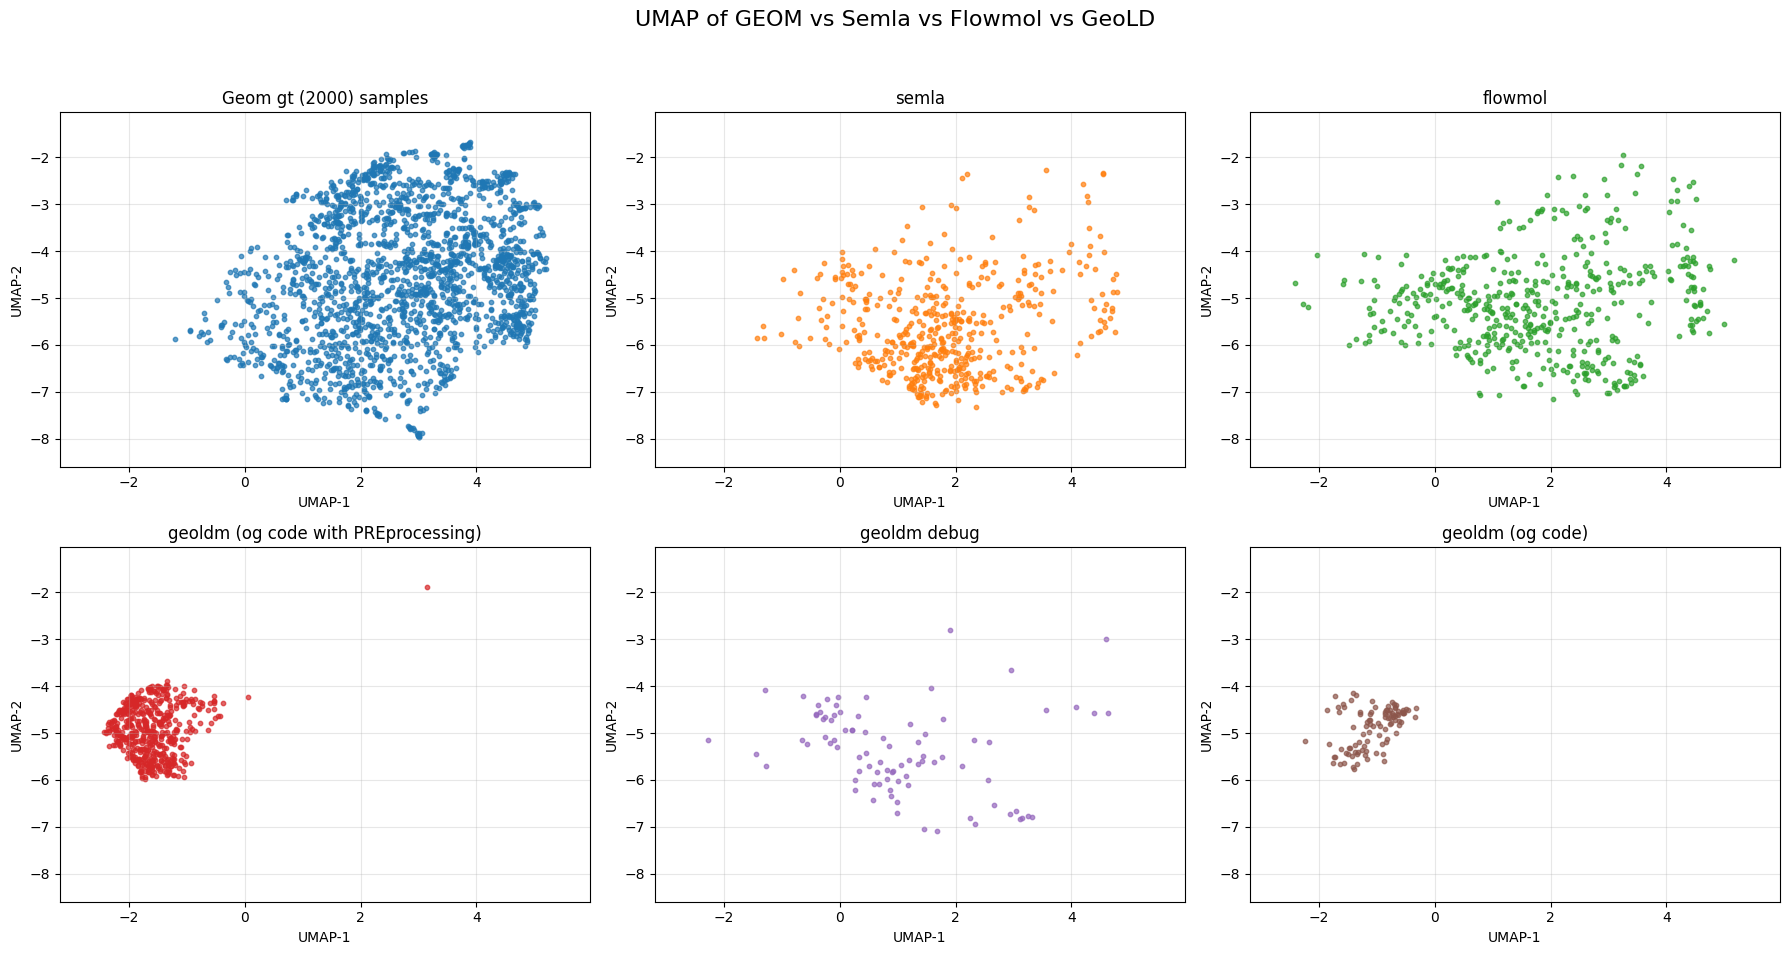

(array([[ 2.3467019 , -2.2044475 ],
        [ 2.2697194 , -2.7355852 ],
        [ 1.2954572 , -3.249318  ],
        ...,
        [-0.72270435, -4.61318   ],
        [-1.3402545 , -5.660565  ],
        [-1.1330942 , -4.9844575 ]], dtype=float32),
 array([0, 0, 0, ..., 5, 5, 5]))

In [3]:
geom_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/geom_fingerprints.npy")
mask = np.random.choice(len(geom_fp), size=2000, replace=False)

semla_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_semla_from_geom.npy")
flowmol_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_flowmol_from_geom.npy")
geoldm_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_geoldm_from_geom.npy")
geoldm_ogmodel = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_geoldm_ogmodel_from_geom.npy")
geoldm_ogmodel_pp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_geoldm_ogmodel_pp_from_geom.npy")
geoldm_ogmodel_prep = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_geoldm_ogmodel_prep_from_geom.npy")
debug_fp = fidelity.read_fingerprints_file("/projects/iktos/pierre/CondGeoLDM/data/fingerprints_data/fp_debug_from_geom.npy")
fidelity.compute_stacked_umap([geom_fp[mask], semla_fp[:500], flowmol_fp[:500], geoldm_ogmodel_prep[:500], debug_fp, geoldm_ogmodel],
                              labels=[f"Geom gt ({len(mask)}) samples", "semla", "flowmol", "geoldm (og code with PREprocessing)", 
                                      "geoldm debug", "geoldm (og code)"],
                              save_path="metrics/figures/umap_geom_global.png",
                              title="UMAP of GEOM vs Semla vs Flowmol vs GeoLD",
                              )

/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/iktos/pierre/CondGeoLDM/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Silhouette Score: 0.000


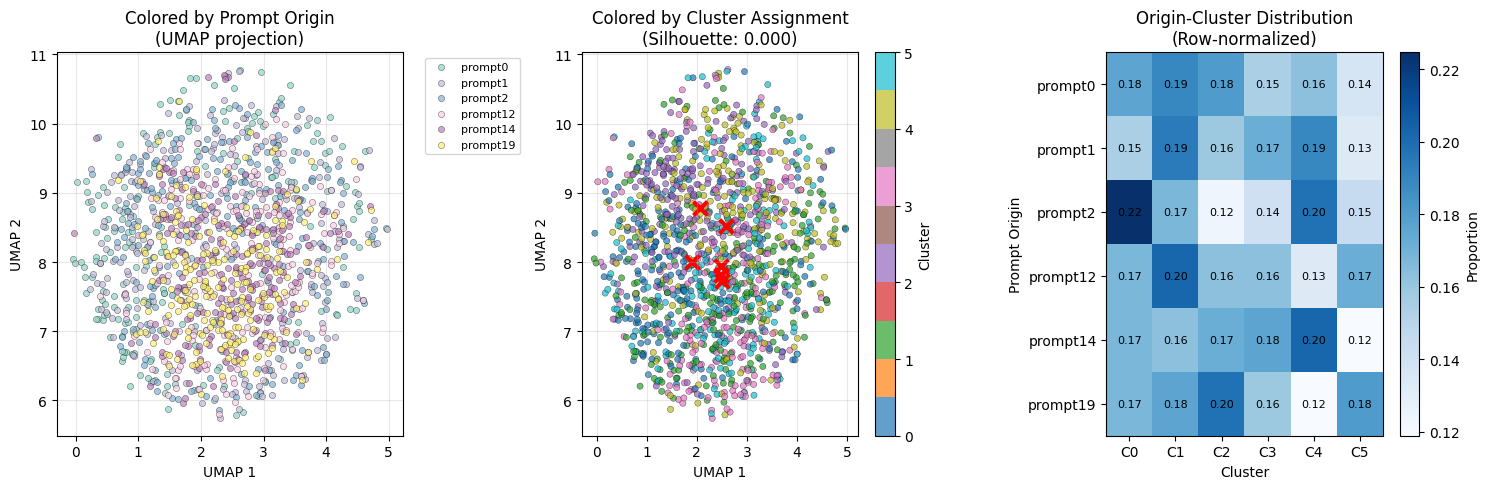


=== Clustering Analysis ===
Total samples: 1362
Feature dimensions: 1024
Number of clusters: 6

--- Samples per origin ---
prompt0: 227 samples
prompt1: 227 samples
prompt2: 227 samples
prompt12: 227 samples
prompt14: 227 samples
prompt19: 227 samples

--- Samples per cluster ---
Cluster 0: 240 samples
Cluster 1: 248 samples
Cluster 2: 226 samples
Cluster 3: 219 samples
Cluster 4: 228 samples
Cluster 5: 201 samples

--- Cluster purity (most common origin per cluster) ---
Cluster 0: prompt2 (21.25% purity)
Cluster 1: prompt12 (18.55% purity)
Cluster 2: prompt19 (19.91% purity)
Cluster 3: prompt14 (18.26% purity)
Cluster 4: prompt14 (20.18% purity)
Cluster 5: prompt19 (20.40% purity)


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score
import umap

def analyze_prompt_clustering(prompt_fps_dict, n_clusters=6, use_umap=False, figsize=(15, 5)):
    """
    Comprehensive clustering analysis of prompt fingerprints
    
    Args:
        prompt_fps_dict: Dictionary with prompt names as keys and fingerprint arrays as values
        n_clusters: Number of clusters for KMeans
        use_umap: If True, use UMAP for dimensionality reduction, otherwise PCA
        figsize: Figure size for plots
    """
    
    # Prepare data more systematically
    prompt_names = list(prompt_fps_dict.keys())[:227]
    prompt_fps = list(prompt_fps_dict.values())[:227]
    
    # Stack all fingerprints
    X = np.vstack(prompt_fps)
    
    # Create labels for origin tracking
    labels_origin = []
    for name, fps in prompt_fps_dict.items():
        labels_origin.extend([name] * len(fps))
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    
    # Dimensionality reduction
    if use_umap:
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
        X_2d = reducer.fit_transform(X)
        method_name = "UMAP"
    else:
        pca = PCA(n_components=2, random_state=42)
        X_2d = pca.fit_transform(X)
        method_name = "PCA"
        print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    
    # Calculate clustering metrics
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg:.3f}")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Plot 1: Color by origin (prompt type)
    ax1 = axes[0]
    colors_origin = plt.cm.Set3(np.linspace(0, 1, len(prompt_names)))
    origin_color_map = {name: colors_origin[i] for i, name in enumerate(prompt_names)}
    
    for i, origin in enumerate(prompt_names):
        idx = [j for j, l in enumerate(labels_origin) if l == origin]
        if idx:  # Check if there are points for this origin
            ax1.scatter(X_2d[idx, 0], X_2d[idx, 1], 
                       c=[origin_color_map[origin]], label=origin, 
                       alpha=0.7, s=20, edgecolors='black', linewidths=0.3)
    
    ax1.set_title(f"Colored by Prompt Origin\n({method_name} projection)")
    ax1.set_xlabel(f"{method_name} 1")
    ax1.set_ylabel(f"{method_name} 2")
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Color by cluster assignment
    ax2 = axes[1]
    colors_cluster = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    scatter = ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, 
                         cmap='tab10', alpha=0.7, s=20, 
                         edgecolors='black', linewidths=0.3)
    
    # Add cluster centers
    if use_umap:
        # For UMAP, we can't directly transform cluster centers, so we approximate
        cluster_centers_2d = []
        for i in range(n_clusters):
            cluster_points = X_2d[cluster_labels == i]
            if len(cluster_points) > 0:
                center = np.mean(cluster_points, axis=0)
                cluster_centers_2d.append(center)
        cluster_centers_2d = np.array(cluster_centers_2d)
    else:
        # For PCA, we can transform the actual cluster centers
        cluster_centers_2d = pca.transform(kmeans.cluster_centers_)
    
    if len(cluster_centers_2d) > 0:
        ax2.scatter(cluster_centers_2d[:, 0], cluster_centers_2d[:, 1], 
                   c='red', marker='x', s=100, linewidths=3, label='Centroids')
    
    ax2.set_title(f"Colored by Cluster Assignment\n(Silhouette: {silhouette_avg:.3f})")
    ax2.set_xlabel(f"{method_name} 1")
    ax2.set_ylabel(f"{method_name} 2")
    ax2.grid(True, alpha=0.3)
    
    # Create colorbar for clusters
    cbar = plt.colorbar(scatter, ax=ax2, ticks=range(n_clusters))
    cbar.set_label('Cluster')
    
    # Plot 3: Cluster composition analysis
    ax3 = axes[2]
    
    # Create confusion matrix between origins and clusters
    confusion_data = np.zeros((len(prompt_names), n_clusters))
    for i, origin in enumerate(prompt_names):
        origin_indices = [j for j, l in enumerate(labels_origin) if l == origin]
        origin_clusters = cluster_labels[origin_indices]
        for cluster in range(n_clusters):
            confusion_data[i, cluster] = np.sum(origin_clusters == cluster)
    
    # Normalize by row (by origin) to show percentages
    confusion_normalized = confusion_data / confusion_data.sum(axis=1, keepdims=True)
    
    im = ax3.imshow(confusion_normalized, cmap='Blues', aspect='auto')
    ax3.set_xticks(range(n_clusters))
    ax3.set_yticks(range(len(prompt_names)))
    ax3.set_xticklabels([f'C{i}' for i in range(n_clusters)])
    ax3.set_yticklabels(prompt_names)
    ax3.set_xlabel('Cluster')
    ax3.set_ylabel('Prompt Origin')
    ax3.set_title('Origin-Cluster Distribution\n(Row-normalized)')
    
    # Add text annotations
    for i in range(len(prompt_names)):
        for j in range(n_clusters):
            text = ax3.text(j, i, f'{confusion_normalized[i, j]:.2f}', 
                           ha="center", va="center", color="black", fontsize=8)
    
    plt.colorbar(im, ax=ax3, label='Proportion')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\n=== Clustering Analysis ===")
    print(f"Total samples: {len(X)}")
    print(f"Feature dimensions: {X.shape[1]}")
    print(f"Number of clusters: {n_clusters}")
    
    print("\n--- Samples per origin ---")
    for name, fps in prompt_fps_dict.items():
        print(f"{name}: {len(fps)} samples")
    
    print("\n--- Samples per cluster ---")
    unique_clusters, counts = np.unique(cluster_labels, return_counts=True)
    for cluster, count in zip(unique_clusters, counts):
        print(f"Cluster {cluster}: {count} samples")
    
    print("\n--- Cluster purity (most common origin per cluster) ---")
    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_origins = [labels_origin[i] for i in cluster_indices]
        if cluster_origins:
            most_common = max(set(cluster_origins), key=cluster_origins.count)
            purity = cluster_origins.count(most_common) / len(cluster_origins)
            print(f"Cluster {cluster}: {most_common} ({purity:.2%} purity)")
    
    return {
        'X_2d': X_2d,
        'cluster_labels': cluster_labels,
        'labels_origin': labels_origin,
        'silhouette_score': silhouette_avg,
        'kmeans_model': kmeans
    }

# Example usage with your data structure:
prompt_fps_dict = {
    "prompt0": prompt0_fp[:227],
    "prompt1": prompt1_fp[:227], 
    "prompt2": prompt2_fp[:227],
    "prompt12": prompt12_fp[:227],
    "prompt14": prompt14_fp[:227],
    "prompt19": prompt19_fp[:227]
}

# Run the analysis
results = analyze_prompt_clustering(prompt_fps_dict, n_clusters=6, use_umap=True)

In [17]:
from pathlib import Path
import pickle
from qm9 import dataset

io_path = Path("/import/pr_iktos/pierre/CondGeoLDM")

with open(io_path / "outputs/jump_xatt_h_3000%_25e_resume" /  "args.pickle", "rb") as f:
    args = pickle.load(f)
dataloaders, _ = dataset.retrieve_dataloaders(args)

Loading JUMP dataset from /projects/iktos/pierre/CondGeoLDM/data/jump/charac_30_h.npy


In [22]:
test_loader = dataloaders["test"]
for batch in test_loader:
    emb = batch["embeddings"].clone()
    break
emb[0]

tensor([ 0.0490,  0.3142, -0.1713,  ...,  0.6353, -0.4829,  0.1525])

In [34]:
import torch.nn.functional as F
print(prompt12_fp[:,0], prompt14_fp[:,0])
cos_sim01 = F.cosine_similarity(emb[1], emb[0], dim=0)
print("Cosine between prompts 0 & 1:" , cos_sim01)
cos_sim02 = F.cosine_similarity(emb[0], emb[19], dim=0)
print("Cosine between 0 & 19:", cos_sim02)
cos_sim12 = F.cosine_similarity(emb[1], emb[19], dim=0)
print("Cosine between 1 & 19:", cos_sim12)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
Cosine between prompts 0 & 1: tensor(-0.0071)
Cosine between 0 &

In [28]:
max_sim = 0
min_sim = 0
all_cos_sims = []
indices = [0, 1, 2, 12, 14, 19]
all_cos_sims = []

for idx, i in enumerate(indices):
    for j in indices[idx+1:]:
        cos_sim = F.cosine_similarity(emb[i], emb[j], dim=0)
        all_cos_sims.append(cos_sim.item())
        print(f"Cosine similarity between {i} and {j}: {cos_sim.item()}")
        # if (cos_sim)> max_sim:
        #     max_sim = cos_sim
        #     print(f"New max sim: {max_sim} between {i} and {j}")
        # if (cos_sim) < min_sim:
        #     min_sim = cos_sim
        #     print(f"New min sim: {min_sim} between {i} and {j}")

# plot all cosi histogram 

# import matplotlib.pyplot as plt
# plt.hist(all_cos_sims, bins=50)
# plt.title("Cosine similarities between 32 embeddings")
# plt.xlabel("Cosine similarity")
# plt.ylabel("Frequency")     
# # plt.savefig("metrics/figures/cosine_similarities_histogram.png")
# plt.show() 



Cosine similarity between 0 and 1: -0.007125344127416611
Cosine similarity between 0 and 2: 0.05235643312335014
Cosine similarity between 0 and 12: 0.10128151625394821
Cosine similarity between 0 and 14: -0.14918577671051025
Cosine similarity between 0 and 19: -0.07063275575637817
Cosine similarity between 1 and 2: 0.019359834492206573
Cosine similarity between 1 and 12: 0.10365933179855347
Cosine similarity between 1 and 14: -0.14346016943454742
Cosine similarity between 1 and 19: 0.3401736915111542
Cosine similarity between 2 and 12: 0.0925578698515892
Cosine similarity between 2 and 14: -0.07008595019578934
Cosine similarity between 2 and 19: 0.025376267731189728
Cosine similarity between 12 and 14: -0.34788158535957336
Cosine similarity between 12 and 19: 0.09008188545703888
Cosine similarity between 14 and 19: -0.08107537776231766


# Checking molecular property distribution

In [57]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
from collections import Counter
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')
# Load molecules from SDF
sdf_path = "/projects/iktos/pierre/sampled_mols/GeoLDM/ogmodel_prep.sdf"

suppl = Chem.SDMolSupplier(sdf_path, removeHs=False, sanitize=True)
mols = [mol for mol in suppl if mol is not None]

# Compute mean number of atoms
num_atoms = [mol.GetNumAtoms() for mol in mols]
mean_num_atoms = np.mean(num_atoms)
std_num_atoms = np.std(num_atoms)
# Compute mean logP
logps = [Descriptors.MolLogP(mol) for mol in mols]
mean_logp = np.mean(logps)
std_logp = np.std(logps)

# Atom type repartition
atom_types = []
for mol in mols:
    atom_types.extend([atom.GetSymbol() for atom in mol.GetAtoms()])
atom_type_counts = Counter(atom_types)

print(f"Mean number of atoms: {mean_num_atoms:.2f}")
print(f"Standard deviation of number of atoms: {std_num_atoms:.2f}")
print(f"Mean logP: {mean_logp:.2f}")
print(f"Standard deviation of logP: {std_logp:.2f}")
print("Atom type repartition:")
for atom, count in atom_type_counts.items():
    print(f"  {atom}: {count/len(mols):.2f}% ({count})")

Mean number of atoms: 51.22
Standard deviation of number of atoms: 15.80
Mean logP: -0.63
Standard deviation of logP: 2.01
Atom type repartition:
  H: 29.60% (20693)
  C: 14.03% (9807)
  N: 4.07% (2845)
  O: 2.93% (2049)
  Br: 0.01% (9)
  S: 0.35% (246)
  Cl: 0.10% (73)
  F: 0.12% (81)
  I: 0.00% (2)
  P: 0.00% (1)


In [58]:
sdf_path = "/projects/iktos/pierre/sampled_mols/semla-flow/predictions.smol.sdf"
suppl = Chem.SDMolSupplier(sdf_path, removeHs=False, sanitize=True)
mols = [mol for mol in suppl if mol is not None]

# Compute mean number of atoms
num_atoms = [mol.GetNumAtoms() for mol in mols]
mean_num_atoms = np.mean(num_atoms)
std_num_atoms = np.std(num_atoms)

# Compute mean logP
logps = [Descriptors.MolLogP(mol) for mol in mols]
mean_logp = np.mean(logps)
std_logp = np.std(logps)

# Atom type repartition
atom_types = []
for mol in mols:
    atom_types.extend([atom.GetSymbol() for atom in mol.GetAtoms()])
atom_type_counts = Counter(atom_types)

print(f"Mean number of atoms: {mean_num_atoms:.2f}")
print(f"Standard deviation of number of atoms: {std_num_atoms:.2f}")
print(f"Mean logP: {mean_logp:.2f}")
print(f"Standard deviation of logP: {std_logp:.2f}")
print("Atom type repartition:")
for atom, count in atom_type_counts.items():
    print(f"  {atom}: {count/len(mols):.2f}% ({count})")

Mean number of atoms: 43.90
Standard deviation of number of atoms: 10.35
Mean logP: 2.72
Standard deviation of logP: 1.33
Atom type repartition:
  H: 21.05% (998083)
  C: 17.32% (821419)
  N: 2.46% (116507)
  O: 2.50% (118423)
  F: 0.11% (5397)
  Cl: 0.11% (5092)
  S: 0.32% (15344)
  P: 0.01% (416)
  Br: 0.02% (1136)
  B: 0.00% (3)
  I: 0.00% (5)
